In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle

import awkward as ak
import mplhep as hep
import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
import re
import copy

import time
from timeout_decorator import timeout

from LoadBatch import *

verbose = False
debug = False

In [2]:
pd.set_option('display.max_columns', None)

!ls ../Data_TestBeam/2023_May/

'CERN Testbeam May 2023 - RunLog.csv'   configs   plots   S1   S2


In [3]:
# make list of files (merge.root)       v
# what are the variables that change for each file?

# (have a list of transimpedance values?)

# save the charge value from the fit

In [4]:
plt.style.use(hep.atlas.style.ATLAS)

In [5]:
# file = "../Data_TestBeam/2020_September/tree_September2020_106_000387.root"
# file = "../Data_TestBeam/2022_February/tree_February2022_502_000822.root"
# file = "../Data_TestBeam/2022_March/merge_March2022_201.root"
# file = "../Data_TestBeam/2022_October/batch302/merged_tracking_scope.root"

# other_df = root_to_df(file, branches)
# other_df

In [6]:
# @timeout(5) # max seconds of running
# def find_min_btw_peaks(data, bins, peak_prominence=None, min_prominence=None, plot=True,
#                        savefig=False, savefig_path='../various plots/', savefig_details='', fig_ax=None):#, rec_depth=0):
#     """
#     Finds the minimun between two peaks, using 'find_peaks()' function. \n
#     Parameters
#     ----------
#     data:           data to be transformed into histogram and of which to find the peaks (e.g. df['pulseHeight_1'])
#     bins:           matplot bins options e.g. int (number of bins), list (bin edges)
#     peak_prominence: "height" of the peaks compared to neighbouring data
#     min_prominence:  "depth" of the min compared to neighbouring data
#     plot:           boolean, default True, if the plot will to be shown
#     Returns
#     -------
#     x_min:          x position of the minimum
#     """
#     if fig_ax:
#         fig, ax = fig_ax
#     else:
#         fig, ax = plt.subplots(figsize=(15,10), dpi=200)
#     ax.semilogy()
    
#     try:
#         hist, bins_hist, _ = ax.hist(data, bins=bins, histtype='step')#, density=True)
#         bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
#         # I can try:
#         density_factor = sum(hist)*np.diff(bins_hist)
#         # Use kernel density estimate instead
#         kde = gaussian_kde(data) * density_factor # should this be hist????
#         smoothed_hist = kde.evaluate(bins_centers)

#         if not peak_prominence: peak_prominence = np.max(smoothed_hist)/100
#         if not min_prominence: min_prominence = np.max(smoothed_hist)/100
#         # find (hopefully two) peaks and plot them
#         peaks_idx, info_peaks = find_peaks(smoothed_hist, prominence=peak_prominence)
#         ax.plot(bins_centers, smoothed_hist, linewidth=1, label='Smoothed hist')
#         ax.plot(bins_centers[peaks_idx], smoothed_hist[peaks_idx], 'x', markersize=10, color='k', label='Peaks')

#         # the recursion meakes it repeat kde.evaluate(), which is very slow, let's just try a loop
#         rec_depth = 0
#         while(rec_depth<10):
#     #         print("peaks:", peaks_idx)
#             if len(peaks_idx)>=2: # find the minimum
#                 local_min, info_min = find_peaks(-smoothed_hist[peaks_idx[0]:peaks_idx[1]], prominence=min_prominence)
#             else:    # if it doesn't work it's because only one peak was found
#                 print(f"Two peaks not found, retrying...")
#                 ax.clear()
#                 peak_prominence *= 0.7    # reduce prominence if the peaks are not found
#                 rec_depth += 1
#                 if rec_depth==10:
#                     print(f"Two peaks not found after {rec_depth} iterations")
#                     return# None
#                 continue

#             if len(local_min)==1:
#                 break
#             elif len(local_min)==0:
#                 print(f"No minimum found, retrying...")
#                 ax.clear()
#                 min_prominence *= 0.7     # reduce prominence if the min is not found
#                 continue
#             elif len(local_min)>1:
#                 print(f"More than one minimum found at: {[bins_centers[min_idx+peaks_idx[0]] for min_idx in local_min]}")
#                 break
#     except:
#         print(f"evaluating kde too long, abort (rec:{rec_depth})")
#         return
#     else:    
#         x_min = bins_centers[local_min[0]+peaks_idx[0]]
#         ax.plot(x_min, smoothed_hist[local_min[0]+peaks_idx[0]], 'o', markersize=10, color='r',
#                 label='Mimimum: %.1f'%x_min, alpha=.7)
#         ax.legend(fontsize=16)
#         if savefig: fig.savefig(f"{savefig_path}find_min_btw_peaks{savefig_details}.jpg")
#         if not plot: plt.close()
#     return  x_min 


In [7]:
# def plot(df, plot_type, batch, *, sensors=None, bins=200, n_DUT=3,
#          savefig=False, savefig_path='../various plots', savefig_details='',
#          **kwrd_arg):
#     """
#     Function to produce the plots \n
#     Parameters
#     ----------
#     df:             FULL dataframe of the data to plot (each plot_type select the data it needs)
#     plot_type:      type of plot, options are:
#                         '2D_Tracks':    2D plot of the reconstructed tracks
#                         '1D_Tracks':    histogram of reconstructed tracks distribution (Xtr and Ytr)
#                         'pulseHeight':  histogram of the pulseHeight of all channels (log scale)
#                         '2D_Sensors':   2D plot of tracks with pulseHeight cut (highlighting the sensors)
#     batch:          batch number
#     sensors:        dictionary of the sensors in this batch
#     bins:           binning options, (int,int) or (bin_edges_list, bin_edges_list), can be different for different plot_type
#     n_DUT:          number of devices under test (3 for each Scope for May 2023)
#     savefig:        boolean option to save the plot
#     savefig_path:   folder where to save the plot
#     savefig_details: optional details for the file name (e.g. distinguish cuts)
    
#     Returns
#     -------
#     fig, ax:        figure and axis objects so that more manipulation can be done
#     """
#     match plot_type:        
#         case "2D_Tracks":        # 2D tracks plots
#             fig, axes = plt.subplots(nrows=1, ncols=n_DUT, figsize=(15,6), sharex='all', sharey='all', dpi=200)
#             fig.tight_layout(w_pad=6, h_pad=4)
#             for i in range(n_DUT):
#                 hist, _, _, _, = axes[i].hist2d(df[f"Xtr_{i}"], df[f"Ytr_{i}"], bins=bins, **kwrd_arg)
#                 if sensors: axes[i].set_title(f"Ch{i+2}\n({sensors[f'Ch{i+2}']})")
#                 else: axes[i].set_title(f"Ch{i+2}")
#                 axes[i].set_aspect('equal')
#                 axes[i].set_xlabel('pixels', fontsize=20)
#                 axes[i].set_ylabel('pixels', fontsize=20)
                
#         case "1D_Tracks":        # 1D tracks plots
#             fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), dpi=200, sharey='all')
#             for i in range(n_DUT):
#                 add_histogram(axes[0], df[f"Xtr_{i}"], label=f"Xtr_{i}", bins=bins[0], **kwrd_arg)
#                 add_histogram(axes[1], df[f"Ytr_{i}"], label=f"Ytr_{i}", bins=bins[1], **kwrd_arg)
#             axes[0].legend(fontsize=16)
#             axes[1].legend(fontsize=16)
#             axes[0].grid('--')
#             axes[1].grid('--')
        
#         case "pulseHeight":       # PulseHeight plot
#             fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10), dpi=200)
#             for i in range(n_DUT+1):
#                 add_histogram(axes, df[f"pulseHeight_{i}"], bins=bins, label=f"sensor: {sensors[f'Ch{i+1}']}", alpha=.8)
#             axes.semilogy()
#             axes.set_xlabel("PulseHeight [mV]", fontsize=20)
#             axes.set_ylabel("Events (log)", fontsize=20)
#             axes.set_title(f"PulseHeight (no cut), batch {batch}, bins {bins}", fontsize=24, y=1.05)
#             axes.set_xlim(left=-10)
#             axes.legend(fontsize=20)
#             axes.grid('--')
            
#         case "2D_Sensors":        # 2D tracks plots filtering some noise out (pulseHeight cut)
#             fig, axes = plt.subplots(nrows=2, ncols=n_DUT, figsize=(20,12), sharex=False, sharey=False, dpi=200)
#             fig.tight_layout(w_pad=6, h_pad=4)
#             for i in range(n_DUT):
#                 print(f"DUT_{i}")
#                 try:
#                     minimum = find_min_btw_peaks(df[f"pulseHeight_{i+1}"], bins='auto', plot=True, fig_ax=(fig,axes[0,i]),
#                                              savefig=False, savefig_details=f"_{batch}_DUT{i}"+savefig_details)
#                 except:
#                     print("find_min_btw_peaks took too long to run, (no plot)")
#                     continue
#                 pulseHeight_filter = np.where(df[f"pulseHeight_{i+1}"]>minimum)
#                 hist, _, _, _, = axes[1,i].hist2d(df[f"Xtr_{i}"].iloc[pulseHeight_filter], df[f"Ytr_{i}"].iloc[pulseHeight_filter],
#                                                 bins=bins, **kwrd_arg)
#                 if sensors: axes[1,i].set_title(f"Ch{i+2}, "+"cut: %.1f"%minimum+f"mV \n({sensors[f'Ch{i+2}']})")
#                 else: axes[1,i].set_title(f"Ch{i+2}")
#                 axes[1,i].set_aspect('equal')
#                 axes[1,i].set_xlabel('pixels', fontsize=20)
#                 axes[1,i].set_ylabel('pixels', fontsize=20)
                    
#         case other:
#             print("""No plot_type found, options are:
#             '2D_Tracks', '1D_Tracks', 'pulseHeight', '2D_Sensors' """)
#             return
        
#     fig.suptitle(f"{plot_type}, batch: {batch} {savefig_details}", fontsize=24, y=1.15)

#     if savefig: fig.savefig(f"{savefig_path}/{plot_type}_{batch}{savefig_details}.jpg", bbox_inches="tight")
#     return fig, axes

#     # Efficiency 2D plot

#     # Efficiency Xtr Ytr

In [8]:
# fig, axes = plot(df["S1"], "2D_Sensors", this_batch, sensors=sensors_list[this_batch]["S1"], bins=bins)
# for ax in axes:
#     ax.set_xlim(500,650)
#     ax.set_ylim(200,400)

In [9]:
pixel_size = 0.0185 #mm

# choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 800,1),
              np.arange(0, 500,1))

bins = (np.arange(450, 700, 1),
        np.arange(150, 500, 1))

small_bins = (np.arange(525, 650, 1),
              np.arange(200, 325, 1))

# I might have to define the bins a bit better because they depend on the limits of the data
# bins = (x_lim['right']-x_lim['left'], y_lim['top']-y_lim['bottom'])

In [ ]:
transimpedance = 4700 #ohm

# Load the dataframe of sensor names
sensors_list = read_pickle("sensors_list.pickle")
dict_of_runs = read_pickle("dict_of_runs.pickle")
if verbose: 
    print(sensors_list)
    print(dict_of_runs)
# I wanna save data from both scopes
# this_batch = 301

branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

this_batch = 301
print("Batch: ", this_batch)
dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes

for S in ["S1","S2"]: # the two scopes
    print(S)
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"    
    df[S] = root_to_df(os.path.join(dir_path[S], file_path), branches)
    df[S] = df[S].drop(columns=columns_to_remove)
#     plot(df[S], "2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
    plot(df[S], "2D_Sensors", this_batch, sensors=sensors_list[this_batch][S], bins=bins,
    savefig=True, savefig_details=f'_{S}')

# plt.close('all')
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins,
#     savefig=True, savefig_details='_S2')


Batch:  301
S1
DUT_0
DUT_1
Evaluating kde timeout n°: 0. Trying with 1/2 number of points
Evaluating kde timeout n°: 1. Trying with 1/2 number of points
Evaluating kde timeout n°: 2. Trying with 1/2 number of points
Evaluating kde timeout n°: 3. Trying with 1/2 number of points
Evaluating kde timeout n°: 4. Trying with 1/2 number of points
Giving up estimating kde
No minimum found, no plot
DUT_2
Evaluating kde timeout n°: 0. Trying with 1/2 number of points


(<Figure size 3000x2000 with 1 Axes>,
 <AxesSubplot:title={'center':'PulseHeight (no cut), batch 301, bins auto'}, xlabel='PulseHeight [mV]', ylabel='Events (log)'>)

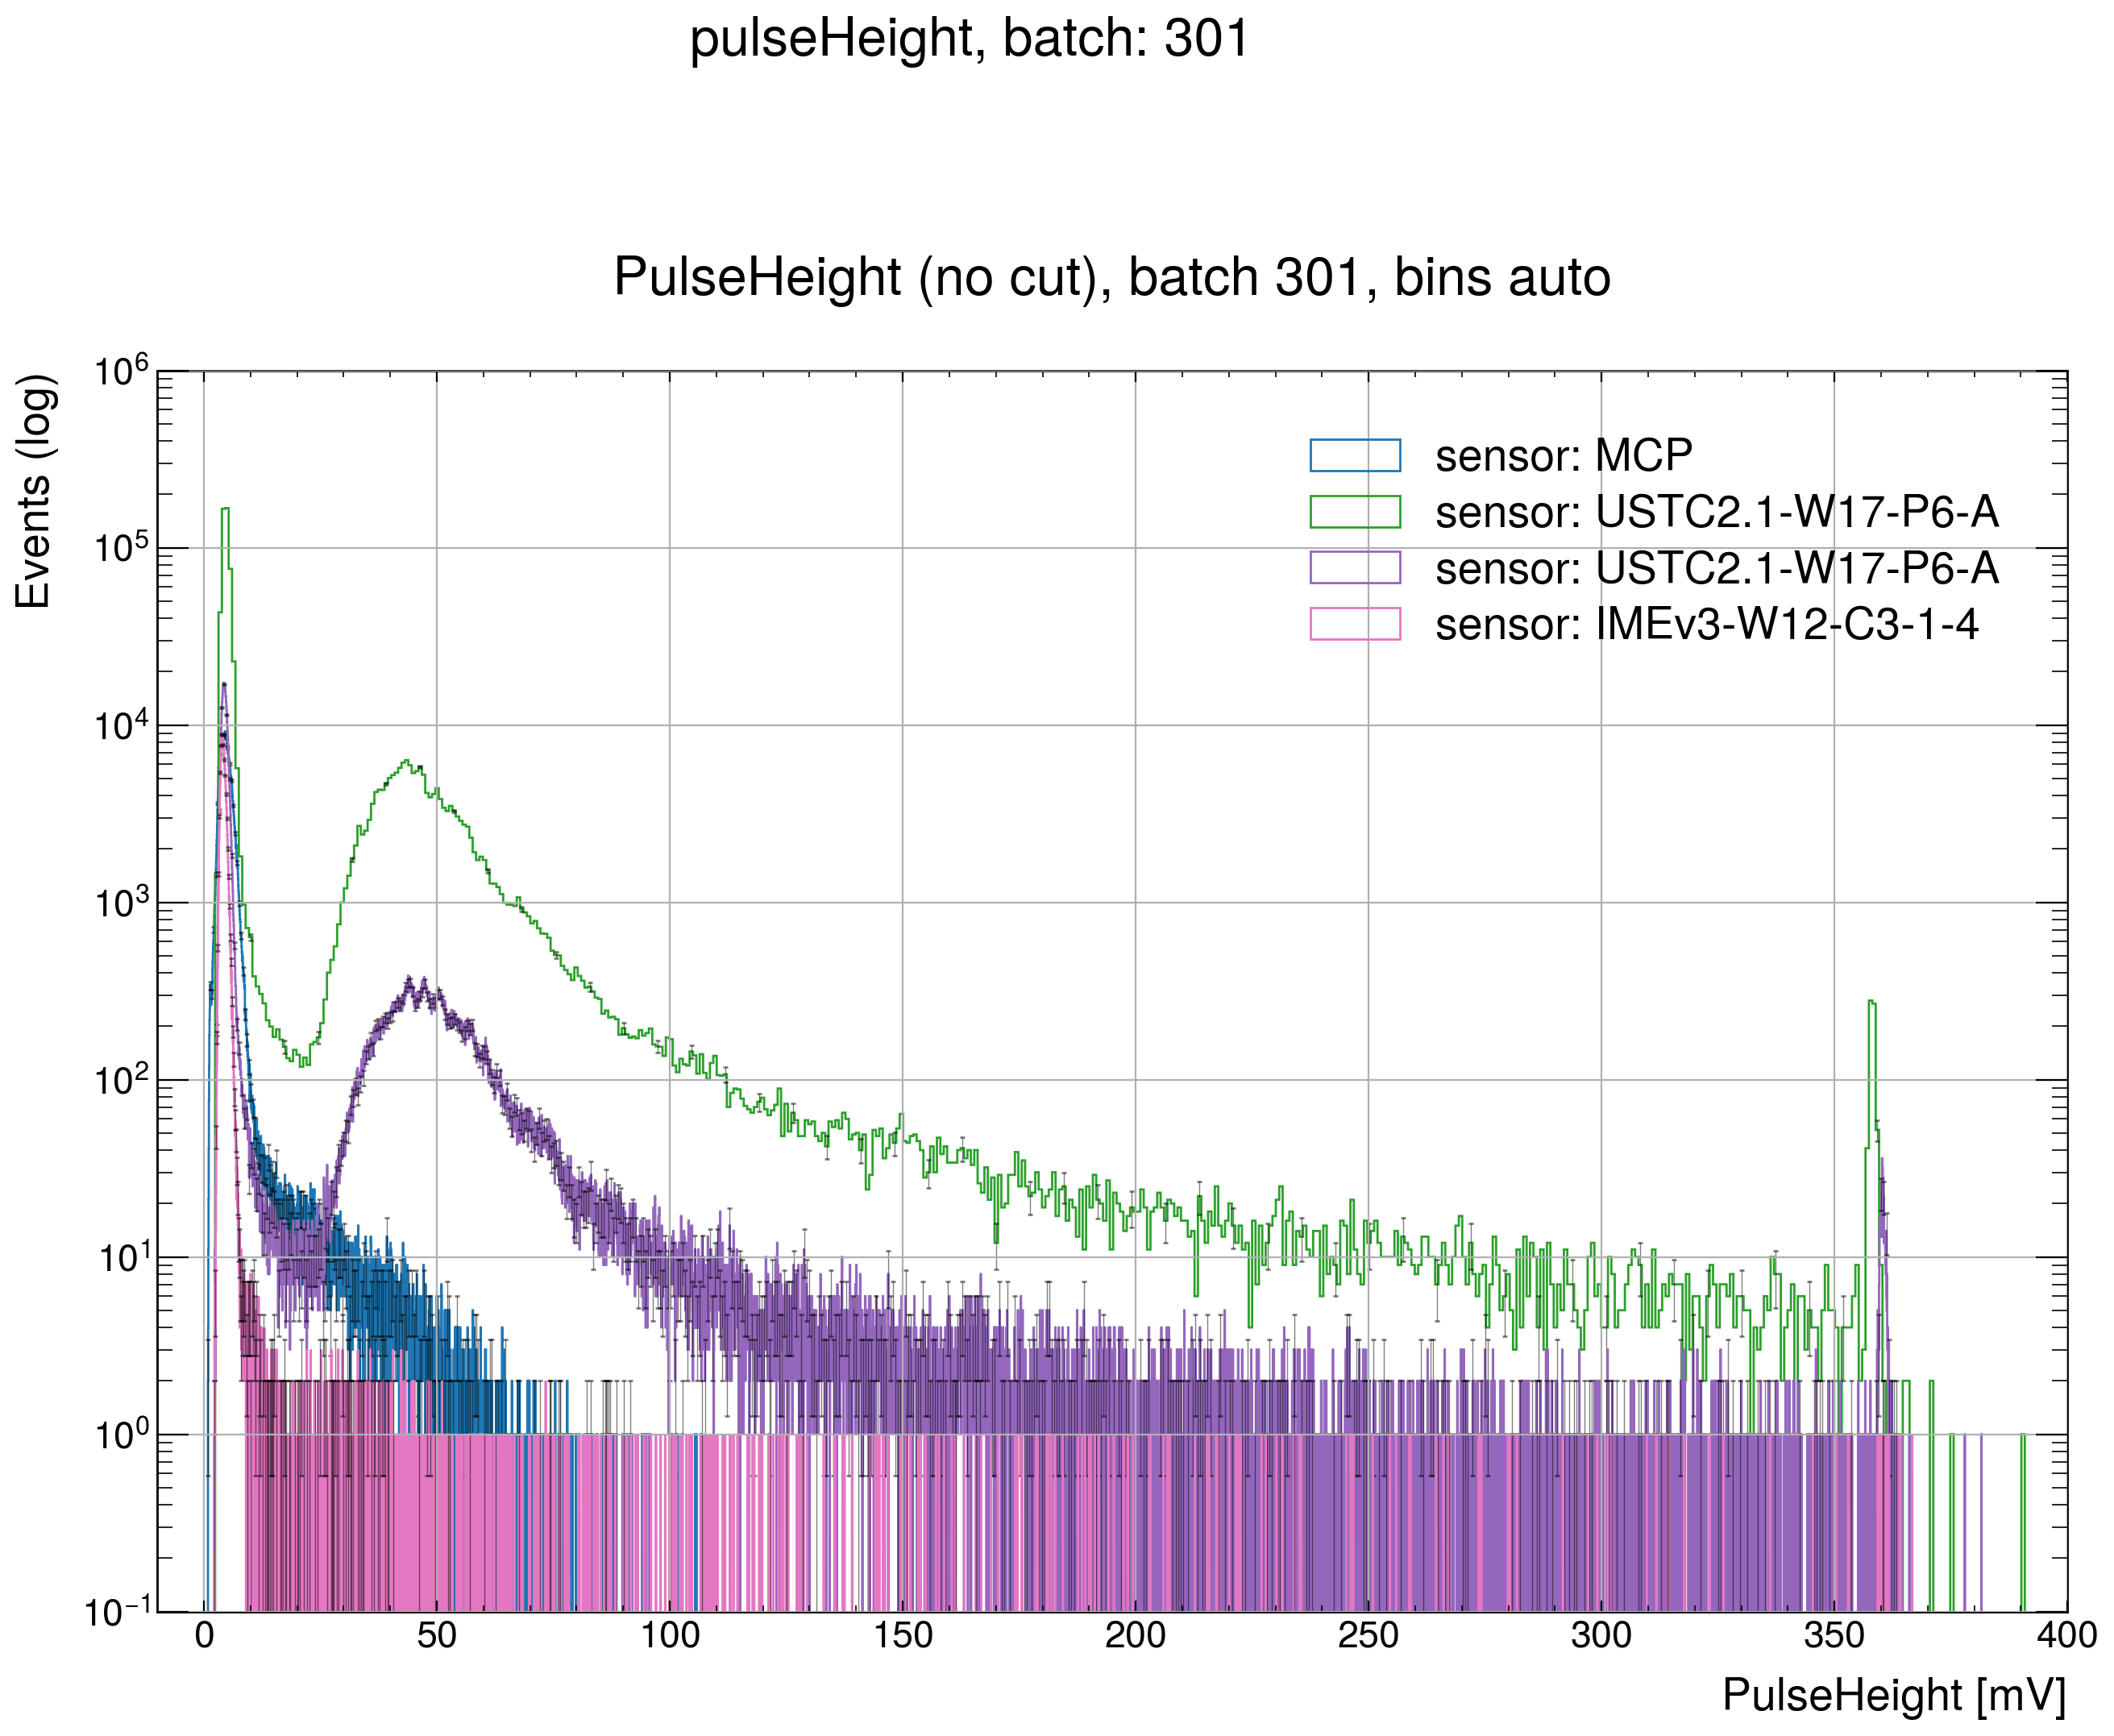

In [11]:
# find_min_btw_peaks(df["S1"]["pulseHeight_3"], bins='auto', plot=True)
data = df["S1"]
my_options = {'markersize':1, 'linewidth':0, 'alpha':0.5,'ecolor':'k', 'elinewidth':0.5, 'capsize':1, 'errorevery':10}
plot(data, "pulseHeight", this_batch, bins='auto', sensors=sensors_list[this_batch]["S1"], **my_options)

(1e-05, 100000)

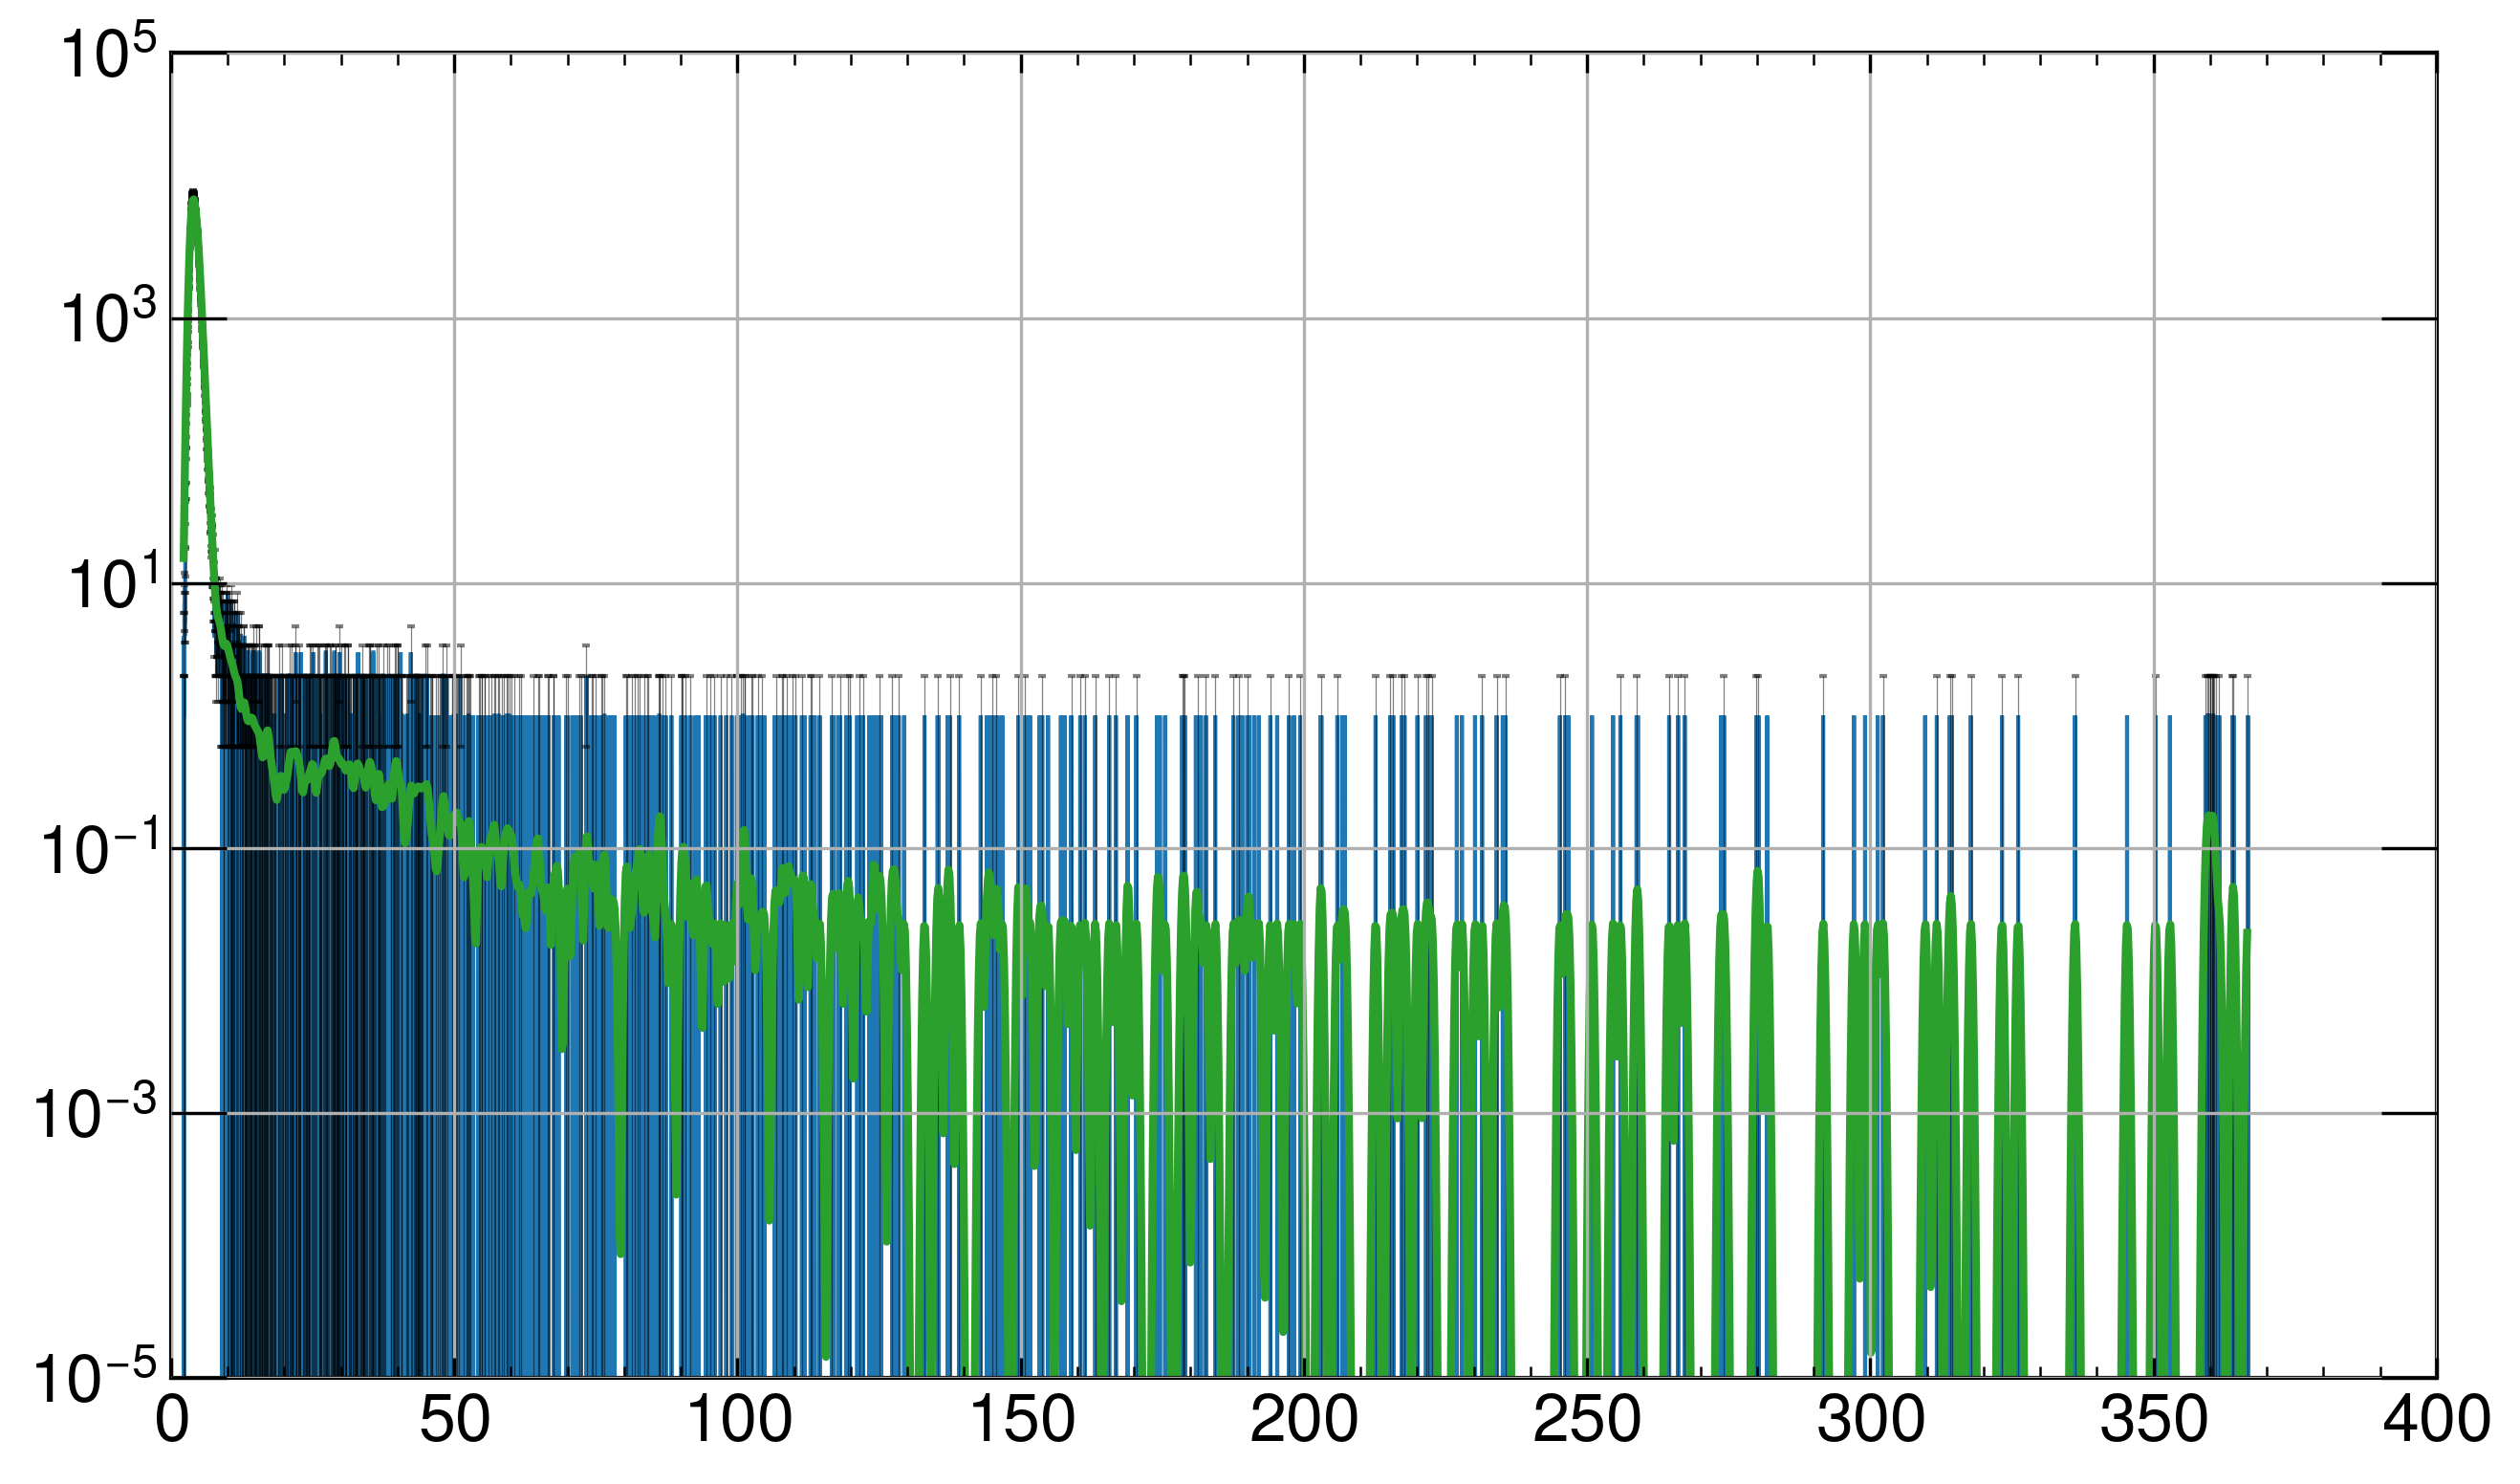

In [12]:
data = df["S1"]["pulseHeight_3"]
kde = gaussian_kde(data)
# my_options = {'markersize':0, 'linewidth':0, 'alpha':0.5,'ecolor':'k', 'elinewidth':0.3, 'capsize':1, 'errorevery':2}
hist, bins, _, fig, ax = plot_histogram(data, poisson_err=True)#, **my_options)
factor = sum(hist)*np.diff(bins)[::10]
bins_centers = (bins[1:]+bins[0:-1])/2
ax.plot(bins_centers[::10], kde.evaluate(bins_centers[::10])*factor)
ax.semilogy()
ax.set_ylim(10**(-5),10**5)
# THE PROBLEM IS IN EVALUATING THE KDE, SO I NEED A WAY TO TIME THAT
# AND IF IT FAILS i CAN JUST REDUCE THE NUMBER OF EVALUATED POINTS,
# LESS PRECISE BUT WAY FASTER

In [43]:
from wrapt_timeout_decorator import timeout
import time

@timeout(2)
def time_limited_kde(number_of_points):
    time.sleep(number_of_points)
    return -10*number_of_points

    
def my_func():
    points = 5
    print("boh")
    N_tries = 5
    for i in range(N_tries):
        print(f"{i}th try")
        try:
            time_limited_kde(points)
        except:
            print(f"error in cycle i={i}")
            points = points//2

my_func()

boh
0th try
error in cycle i=0
1th try
error in cycle i=1
2th try
3th try
4th try


In [14]:
asdopghas

NameError: name 'asdopghas' is not defined

In [ ]:
for S in ["S1","S2"]: # the two scopes
#     if S=="S1": continue
    for this_batch in dict_of_runs[S].keys():
        print("Batch: ", this_batch)
        dir_path = f"../Data_TestBeam/2023_May/{S}/"
        file_path = f"tree_May2023_{S}_{this_batch}.root"    
        try:
            df = root_to_df(os.path.join(dir_path, file_path), branches)
        except:
            print("something wrong reading the file")
            continue
        df = df.drop(columns=columns_to_remove)
#         plot(df,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
#              savefig=True, savefig_details=f'_{S}')
#         plot(df,"1D_Tracks", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
#              savefig=True, savefig_details=f'_{S}')
#         bins = 1000
#         plot(df, "pulseHeight", batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
#             savefig=True, savefig_details=f"_{S}_bins_{bins}")
        plot(df, '2D_Sensors', batch=this_batch, sensors=sensors_list[this_batch][S], bins=bins,
             savefig=True, savefig_details=f'_{S}')
        plt.close()

In [ ]:
df["S1"]["pulseHeight_1"]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
hist, bins_hist, _ = ax.hist(df["S1"]["pulseHeight_3"], bins='auto', histtype='step', density=True)
ax.semilogy()
ax.grid('--')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
kernel_size = int(np.max(df["S1"]["pulseHeight_3"])/5)  # kernel: 20% of full range of values
smoothed_hist = np.convolve(hist, np.ones(kernel_size)/kernel_size, mode='same')
ax.plot(bins_centers, smoothed_hist)
kde = gaussian_kde(df["S1"]["pulseHeight_3"])
ax.plot(bins_centers, kde.evaluate(bins_centers))


In [ ]:
find_min_btw_peaks(df["S1"]["pulseHeight_3"], bins='auto', plot=True, fig_ax=(fig, ax))

In [ ]:
# I was trying to plot the FE-I4 mask but it does not quite work

# # Create a figure and axis
# fig, ax = plt.subplots()

# # Define the coordinates, width, and height of multiple rectangles
# rectangles = [(30,205,5,25), # x,y,width, height
# (35,205,5,25),
# (29,165,5,25),
# (29,160,5,25),
# (34,180,5,24),
# (39,180,15,24)]

# # Loop through the list of rectangles and draw them
# for rect in rectangles:
#     x, y, width, height = rect
#     ax.add_patch(mpatches.Rectangle((x, y), width, height, fill=True))

# # Set axis limits if needed
# ax.set_xlim(25, 60)
# ax.set_ylim(150, 240)

# # Display the plot
# plt.gca().set_aspect('equal', adjustable='box')  # Make sure aspect ratio is equal
# plt.show()

In [ ]:
dir_path = f"../Data_TestBeam/2023_May/S1/"
run = 9723
file_path = f"tree00{run}.root"    
df_run = root_to_df(os.path.join(dir_path, file_path), branches)
df_run = df_run.drop(columns=columns_to_remove)
    
plot(df_run,"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=bins,
    savefig=True, savefig_details=f"_single_run_{run}")
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

In [ ]:
plot(df["S1"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S1"], bins=large_bins)
plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=large_bins)

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=200, sharex='all', sharey='all')

# fig, ax = plot_histogram(df["S2"]["Xtr_0"])
# for i in range(3):
plot(df["S2"], "1D_Tracks", this_batch, sensors_list[this_batch]["S2"])
#     add_histogram(axes[0], df["S2"][f"Xtr_{i}"])
#     add_histogram(axes[1], df["S2"][f"Ytr_{i}"])
# add_histogram(ax, df["S2"]["Xtr_1"])
# add_histogram(ax, df"S2"]["Xtr_2"])
# ax.semilogy()

In [ ]:
fig, ax = plot_histogram(df["S2"]["Ytr_0"])
add_histogram(ax, df["S2"]["Ytr_1"])
add_histogram(ax, df["S2"]["Ytr_2"])
# ax.semilogy()

In [ ]:
# choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
# bins = (np.arange(x_lim['left'], x_lim['right'],1),
#         np.arange(y_lim['bottom'], y_lim['top'],1))

# I wanna make this into a function

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=300)#, sharex='all', sharey='all')
fig.tight_layout(w_pad=6, h_pad=6)

for idx, scope in enumerate(['S1','S2']):
    for i in (0,1,2):
        Xtr = df[scope][f"Xtr_{i}"]
        Ytr = df[scope][f"Ytr_{i}"]
        hist, _, _, _, = axes[idx,i].hist2d(Xtr, Ytr, bins=bins)
        axes[idx,i].set_title(f"""Ch{i+1} ({sensors_list[this_batch][scope]['Ch'+f'{i+1}']}) \n 
        batch: {this_batch}""")
        axes[idx,i].set_aspect('equal')
        axes[idx,i].set_xlabel('pixels', fontsize=20)
        axes[idx,i].set_ylabel('pixels', fontsize=20)

In [ ]:
sensors_list

In [ ]:
# let's pause this because calculating peaks from histogram is way faster

# x_axis = np.linspace(-5,100,500)
# pulse_kde = gaussian_kde(dataset=df["S1"]["pulseHeight_1"].to_numpy()).evaluate(x_axis)

# peaks = find_peaks(pulse_kde)[0]
# minimun = find_peaks(-pulse_kde[peaks[0]:peaks[1]])
# print(x_axis[minimun[0]+peaks[0]])
# # minimum = find_min_kde(df["S1"]["pulseHeight_1"], x_axis)
# plt.plot(x_axis, pulse_kde)
# plt.plot(x_axis[peaks], pulse_kde[peaks], 'x')
# plt.plot(x_axis[minimun[0]+peaks[0]], pulse_kde[minimun[0]+peaks[0]], 'x')

In [ ]:
# Get the sensors names
this_scope = "S1"
these_sensors = list(sensors_list[this_batch][this_scope].values())
print(these_sensors)

# PulseHeight plot
fig, ax = plot_histogram(df[this_scope].loc[:,"pulseHeight_0":"pulseHeight_2"], label=these_sensors, bins=500)
ax.set_xlim(-4,100)
ax.semilogy()
ax.set_xlabel("pulseHeight [mV]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"PulseHeight of all sensors on {this_scope} (no cut)", fontsize=24, y=1.05)
ax.legend(fontsize=20)

# fig.savefig(f"various plots/pulseheight_plot_all_sensors_{this_batch}.jpg")

In [ ]:
prominence = 500
distance = 20
bins = 1000
this_scope = 'S1'

fig, ax = plt.subplots(figsize=(12,8), dpi=300)
global_min = find_min_btw_peaks(df[this_scope]["pulseHeight_1"], bins, prominence, distance)
ax.set_xlim(0,100)
ax.set_xlabel("PulseHeight [mV]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.grid('--')
ax.semilogy()
ax.legend(fontsize=20)

ax.set_title(f"pulseHeight min between peaks, Ch2", fontsize=24, y=1.05)

# fig.savefig(f"various plots/pulseheight_min_between_picks_{this_batch}_{these_sensors[1]}.jpg")

In [ ]:
# this_scope = 'S1'
# # initilize all the empty dicts ONLY if they don't already exist (so I can keep previous ones)
# # might be useless later on
# try: dict_mins[this_batch][this_scope] = {}
# except:
#     try:
#         dict_mins[this_batch] = {}
#         dict_mins[this_batch][this_scope] = {}
#     except:
#         dict_mins = {}
#         dict_mins[this_batch] = {}
#         dict_mins[this_batch][this_scope] = {}

# prominence = 500
# distance = 20 

# # find the mimimum for each pulseHeight
# for name in ['pulseHeight_1', 'pulseHeight_2']:
#     print(name)
# #     bins = 1000
#     dict_mins[this_batch][this_scope][name] = find_min_btw_peaks(df[this_scope][name], bins, prominence, distance, plot=False)
#     print("min:", dict_mins[this_batch][this_scope][name])

# dict_mins

In [ ]:
transimpedance = 4700


In [ ]:
# Filter condi-tions
min_1 = dict_mins[this_batch][this_scope]["pulseHeight_1"]
min_2 = dict_mins[this_batch][this_scope]["pulseHeight_2"]
filter_1 = (df[this_scope]["pulseHeight_1"]>min_1).combine(df[this_scope]["pulseHeight_1"]<350, my_and)
filter_2 = (df[this_scope]["pulseHeight_2"]>min_2).combine(df[this_scope]["pulseHeight_2"]<350, my_and)

In [ ]:
this_scope = 'S1'
bins = (200,200)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=300, sharex='all', sharey='all')
fig.tight_layout(w_pad=6)

Xtr_0 = df[this_scope]["Xtr_0"]#*pixel_size
Ytr_0 = df[this_scope]["Ytr_0"]#*pixel_size
# hist, x_bins, y_bins, _ = ax[0].hist2d(Xtr_0, Ytr_0, bins=bins) # set the same bins for all plots
# axes[0].set_title(f"hits on Ch1 no cut ({sensors_list[this_batch][this_scope]['Ch1']})")

Xtr_1 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_1 = df[this_scope]["Ytr_1"]#*pixel_size
hist, x_bins, y_bins, _ = axes[0].hist2d(Xtr_1, Ytr_1, bins=bins) # set the same bins for all plots
axes[0].set_title(f"Tracks on Ch2 no cut", fontsize=20)

# Xtr_1cut = df[this_scope]["Xtr_1"].iloc[np.where(filter_1)]#*pixel_size
# Ytr_1cut = df[this_scope]["Ytr_1"].iloc[np.where(filter_1)]#*pixel_size
# axes[1].hist2d(Xtr_1cut, Ytr_1cut, bins=(x_bins,y_bins))
# axes[1].set_title(f"Tracks on Ch2 pulseheight cut", fontsize=20)

Xtr_2cut = df[this_scope]["Xtr_2"].iloc[np.where(filter_2)]#*pixel_size
Ytr_2cut = df[this_scope]["Ytr_2"].iloc[np.where(filter_2)]#*pixel_size
axes[1].hist2d(Xtr_2cut, Ytr_2cut, bins=(x_bins,y_bins))
axes[1].set_title(f"hits on Ch3 pulseheight cut ({sensors_list[this_batch][this_scope]['Ch3']})")

# fig.suptitle(f'Hit positions on batch 301', size=16)

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(**x_lim)
    ax.set_ylim(**y_lim)
    ax.set_xlabel('pixels', fontsize=20)
    ax.set_ylabel('pixels', fontsize=20)
    secx = ax.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm', fontsize=20)
    secy.set_ylabel('mm', fontsize=20)

# fig.savefig(f"various plots/hits_on_USTC_{this_batch}_pulseheight_cut.jpg", bbox_inches="tight")

In [ ]:
# figure out the geometry cut and put it into a dict
edges = {}
edges["Ch2"] = {}

edges["Ch2"]["left"], edges["Ch2"]["right"] = find_edges(Xtr_1cut) # previous Xtr cut
edges["Ch2"]["bottom"], edges["Ch2"]["top"] = find_edges(Ytr_1cut)
xgeometry_1 = (df[this_scope]["Xtr_1"]>edges["Ch2"]["left"]).combine((
                df[this_scope]["Xtr_1"]<edges["Ch2"]["right"]), my_and)
ygeometry_1 = (df[this_scope]["Ytr_1"]>edges["Ch2"]["bottom"]).combine((
                df[this_scope]["Ytr_1"]<edges["Ch2"]["top"]), my_and) 
geometry_1 = xgeometry_1.combine(ygeometry_1, my_and)

edges["Ch3"] = {}
edges["Ch3"]["left"], edges["Ch3"]["right"] = find_edges(Xtr_2cut) 
edges["Ch3"]["bottom"], edges["Ch3"]["top"] = find_edges(Ytr_2cut)
xgeometry_2 = (df[this_scope]["Xtr_2"]>edges["Ch3"]["left"]).combine((
                df[this_scope]["Xtr_2"]<edges["Ch3"]["right"]), my_and)
ygeometry_2 = (df[this_scope]["Ytr_2"]>edges["Ch3"]["bottom"]).combine((
                df[this_scope]["Ytr_2"]<edges["Ch3"]["top"]), my_and) 
geometry_2 = xgeometry_2.combine(ygeometry_2, my_and)

In [ ]:
left_edge, right_edge = find_edges(Xtr_1cut)

fig, ax = plt.subplots(figsize=(15,8))
hist, bins, _ = plt.hist(Xtr_1cut, bins='auto', histtype='step', label=f'Xtr sensor: {these_sensors[1]}')
ax.plot((bins[:-1]+bins[1:])/2, np.gradient(hist), label='gradient of Xtr')
ax.axvline(left_edge, color='g', linestyle='--', label='left edge')
ax.axvline(right_edge, color='r', linestyle='--', label='right edge')
ax.set_title(f"Xtr_1 distribution of {these_sensors[1]} (with pulseheight cut)", fontsize=24, y=1.05)
ax.set_xlim(400,700)
ax.set_xlabel("Position (pixels)", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.grid('--')
ax.legend(fontsize=20, loc='upper left')

fig.savefig(f"various plots/locating_edges_Xtr_of_{these_sensors[1]}.jpg")

In [ ]:
data_pulse_filter = df["S1"]["charge_2"].iloc[np.where(filter_2)]/transimpedance
data_pulse_geo_filter = df["S1"]["charge_2"].iloc[np.where(filter_2 & geometry_2)]/transimpedance
data_geo_filter = df["S1"]["charge_2"].iloc[np.where(geometry_2)]/transimpedance

# I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _ = ax.hist(df["S1"]["charge_2"]/transimpedance, bins='auto', label="no cut", histtype='step', alpha=.5, color='#0000ff')
add_histogram(ax, data_pulse_filter, bins=bins_for_all, label="pulseheight cut", alpha=.5, color='#00ff00')
add_histogram(ax, data_pulse_geo_filter, bins=bins_for_all, label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
add_histogram(ax, data_geo_filter, bins=bins_for_all, label="geometry cut", alpha=.5, color='#505050') # #ffff00
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot with various cuts", fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,50)
ax.semilogy()
ax.legend(fontsize=20)

fig.savefig(f"various plots/charge_plot_various_cuts_{this_batch}.jpg")

In [ ]:
print(find_edges(Xtr_1cut), find_edges(Ytr_1cut))
# (right_edge-left_edge)*pixel_size
# (top_edge-bottom_edge)*pixel_size

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=300, sharex='all', sharey='all')
fig.tight_layout(w_pad=4)

Xtr_0 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_0 = df[this_scope]["Ytr_1"]#*pixel_size
ax[0].hist2d(Xtr_0, Ytr_0, bins=(x_bins, y_bins))
ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch1']} (Ch1)")

Xtr_1geo = df[this_scope]["Xtr_1"].iloc[np.where(filter_1 & geometry_1)]#*pixel_size
Ytr_1geo = df[this_scope]["Ytr_1"].iloc[np.where(filter_1 & geometry_1)]#*pixel_size
ax[1].hist2d(Xtr_1geo, Ytr_1geo, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")

Xtr_2cut = df[this_scope]["Xtr_2"].iloc[np.where(filter_2 & geometry_2)]#*pixel_size
Ytr_2cut = df[this_scope]["Ytr_2"].iloc[np.where(filter_2 & geometry_2)]#*pixel_size
ax[2].hist2d(Xtr_2cut, Ytr_2cut, bins=(x_bins, y_bins))
ax[2].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")

# fig.suptitle(f'Hit positions on batch 301', size=16)

for ax_single in ax:
#     ax_single.axis('equal')
    ax_single.set_xlim(**x_lim)
    ax_single.set_ylim(**y_lim)
    ax_single.set_xlabel('pixels')
    ax_single.set_ylabel('pixels')
    secx = ax_single.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax_single.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm')
    secy.set_ylabel('mm')

fig.savefig(f"various plots/hits_on_USTC_{this_batch}_geometry_cut.jpg", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.tight_layout(w_pad=5)

Xtr_1cut = df[this_scope]["Xtr_1"].iloc[np.where(filter_1)]#*pixel_size
Ytr_1cut = df[this_scope]["Ytr_1"].iloc[np.where(filter_1)]#*pixel_size

ax[0].hist2d(Xtr_1cut, Ytr_1cut, bins=(x_bins,y_bins))
# ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2) \n pulseheight cut")
ax[0].set_title(f"2D hits on  (Ch2) \n pulseheight cut")

# Define bin edges with a bin width of 1
x_bins_pixels = np.arange(np.round(edges["Ch2"]["left"]), np.round(edges["Ch2"]["right"])+1, 1)
y_bins_pixels = np.arange(np.round(edges["Ch2"]["bottom"]), np.round(edges["Ch2"]["top"])+1, 1)
print(f"pixel bins intervals: X=[{min(x_bins_pixels)}, {max(x_bins_pixels)}], \
Y=[{min(y_bins_pixels)}, {max(y_bins_pixels)}]")

Xtr_1geo = df[this_scope]["Xtr_1"].iloc[np.where(geometry_1 & filter_1)]#*pixel_size
Ytr_1geo = df[this_scope]["Ytr_1"].iloc[np.where(geometry_1 & filter_1)]#*pixel_size
ax[1].hist2d(Xtr_1geo, Ytr_1geo, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2) \n pulseheight cut and geometry cut")

for ax_single in ax:
    ax_single.set_aspect('equal')
    ax_single.set_xlim(**x_lim)
    ax_single.set_ylim(**y_lim)
    ax_single.set_xlabel('pixels')
    ax_single.set_ylabel('pixels')
    secx = ax_single.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax_single.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm')
    secy.set_ylabel('mm')
    
# fig.savefig(f"various plots/hits_on_USTC_{this_batch}_geometry_cut_sidebyside.jpg", bbox_inches="tight")

In [ ]:
# I would like a bin definition that fits with the pixels
sensors_list[this_batch][this_scope]['Ch2']

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300, sharex='all')
fig.tight_layout(w_pad=4)

Xtr_1 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_1 = df[this_scope]["Ytr_1"]#*pixel_size
ax[0].hist2d(Xtr_1, Ytr_1, bins=(x_bins, y_bins))
ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")
ax[0].set_aspect('equal')

Xtr_2 = df[this_scope]["Xtr_2"]#*pixel_size
Ytr_2 = df[this_scope]["Ytr_2"]#*pixel_size
ax[1].hist2d(Xtr_2, Ytr_2, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")
ax[1].set_aspect('equal')


## Efficiency Study

In [ ]:
# efficiency study
charge_threshold = 2 #fC
transimpedance = 4700 
bins = (x_bins_pixels, y_bins_pixels)

total_events_in_bin, x_edges, y_edges,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1)],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_1)],
                                                     bins=bins)#, range=(x_lim.values(), y_lim.values()))

# Create a boolean mask for events above the threshold
events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

 # Calculate the number of events above threshold in each bin
events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1.combine(events_above_threshold, my_and))],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_1.combine(events_above_threshold, my_and))],
                                                    bins=(x_edges, y_edges))
# plt.axis('equal')
plt.close()

# Calculate the efficiency for each bin
efficiency_map = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                           where=total_events_in_bin!=0,
                           out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

In [ ]:
fig = plt.figure(figsize=(7.28, 6), dpi=200)
plt.imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='equal', vmin=0, vmax=100)
# fig.tight_layout(pad=7)
plt.colorbar(label='Efficiency')
plt.xlabel('X Position', fontsize=20)
plt.ylabel('Y Position', fontsize=20)
plt.title(f'2D Efficiency restricted to ~1.3x1.3mm² \n (Charge > {charge_threshold} fC) Ch2',
         fontsize=24, y=1.05)
plt.axis('equal')
# plt.xlim(**x_lim)
# plt.ylim(**y_lim)
plt.show()
fig.savefig(f"various plots/Efficiency_heatmap_full_surface_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

In [ ]:
# make a 1d plot (histogram) of the efficiency
# bins = 40
total_events_in_bin1D, bins_edges, _ = plt.hist(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1)],
                                                     bins=x_bins_pixels, histtype='step')

# Create a boolean mask for events above the threshold
events_above_threshold1D = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

# Calculate the number of events above threshold in each bin
events_above_threshold_in_bin1D, _, _ = plt.hist(df["S1"]["Xtr_1"].iloc[np.where(
                                            geometry_1.combine(events_above_threshold1D, my_and))],
                                            bins=x_bins_pixels, histtype='step')
plt.close()

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

eff, err = efficiency_k_n(events_above_threshold_in_bin1D, total_events_in_bin1D)
ax.step(bins_centers, eff, where='mid')
sigma_coeff = 1
ax.errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
            label=f"error: {sigma_coeff}$\sigma$")

ax.set_title(f"X axis projection of efficiency, Ch2", fontsize=24, y=1.05)
ax.set_xlabel("X position (pixels)", fontsize=20)
ax.set_ylabel("Efficiency", fontsize=20)
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/X_axis_projection_efficiency_USTC_{this_batch}.jpg")

In [ ]:
# make a 1d plot (histogram) of the efficiency
# bins = 40
total_events_in_bin1D, bins_edges, _ = plt.hist(df[this_scope]["Ytr_1"].iloc[np.where(geometry_1)],
                                                     bins=y_bins_pixels, histtype='step')

# Create a boolean mask for events above the threshold
events_above_threshold1D = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

# Calculate the number of events above threshold in each bin
events_above_threshold_in_bin1D, _, _ = plt.hist(df["S1"]["Ytr_1"].iloc[np.where(
                                            geometry_1.combine(events_above_threshold1D, my_and))],
                                            bins=y_bins_pixels, histtype='step')
plt.close()

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

eff, err = efficiency_k_n(events_above_threshold_in_bin1D, total_events_in_bin1D)
ax.step(bins_centers, eff, where='mid')
sigma_coeff = 1
ax.errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
            label=f"error: {sigma_coeff}$\sigma$")

ax.set_title(f"Y axis projection of efficiency, Ch2", fontsize=24, y=1.05)
ax.set_xlabel("Y position (pixels)", fontsize=20)
ax.set_ylabel("Efficiency (%)", fontsize=20)
ax.grid('--')
ax.legend() 
# fig.savefig(f"various plots/Y_axis_projection_efficiency_USTC_{this_batch}.jpg")

In [ ]:
# total efficiency
transimpedance = 4700 # 10700
efficiency_range = []
threshold_range = np.arange(0.5, 20, 0.5)

for charge in threshold_range:
    efficiency_range.append(efficiency(
        df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance, charge, percentage=False))

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range,'o', 
        label=f"Total tracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size}")
ax.set_title(f"Total efficiency depending on threshold charge \n \
on full surface of {these_sensors[1]}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)")
ax.set_ylabel("Total efficiency (%)")
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/Total_efficiency_change_USTC_{this_batch}.jpg")

## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

In [ ]:
edges_central = copy.deepcopy(edges) # make a copy of edges{}
new_width = 0.5 # mm
new_width_pixel = np.ceil(new_width/pixel_size) # 500um = 0.5mm

for ch, values in edges.items():
    # define the new edges as 1/2 the new edge size to the left and right (bottom and top) from the center
    central_pos = (edges[ch]["left"] + edges[ch]["right"])/2  # center
    edges_central[ch]["left"] = central_pos - new_width_pixel/2    # center - width/2
    edges_central[ch]["right"] = central_pos + new_width_pixel/2   # center + width/2
    
    central_pos = (edges[ch]["bottom"]+edges[ch]["top"])/2
    edges_central[ch]["bottom"] = central_pos - new_width_pixel/2
    edges_central[ch]["top"] = central_pos + new_width_pixel/2

xgeometry_1 = (df[this_scope]["Xtr_1"]>edges_central["Ch2"]["left"]).combine((
                df[this_scope]["Xtr_1"]<edges_central["Ch2"]["right"]), my_and)
ygeometry_1 = (df[this_scope]["Ytr_1"]>edges_central["Ch2"]["bottom"]).combine((
                df[this_scope]["Ytr_1"]<edges_central["Ch2"]["top"]), my_and) 
geometry_small_1 = xgeometry_1.combine(ygeometry_1, my_and)

xgeometry_2 = (df[this_scope]["Xtr_2"]>edges_central["Ch3"]["left"]).combine((
                df[this_scope]["Xtr_2"]<edges_central["Ch3"]["right"]), my_and)
ygeometry_2 = (df[this_scope]["Ytr_2"]>edges_central["Ch3"]["bottom"]).combine((
                df[this_scope]["Ytr_2"]<edges_central["Ch3"]["top"]), my_and) 
geometry_small_2 = xgeometry_2.combine(ygeometry_2, my_and)

In [ ]:
print(edges["Ch2"])
print(edges_central["Ch2"])

In [ ]:
# efficiency study
charge_threshold = 2 #fC
transimpedance = 4700 
bins = (int(new_width_pixel), int(new_width_pixel))

total_events_in_bin, x_edges_small, y_edges_small,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1)],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1)],
                                                     bins=bins)#, range=(x_lim.values(), y_lim.values()))

# Create a boolean mask for events above the threshold
events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance > charge_threshold

 # Calculate the number of events above threshold in each bin
events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
                                                    bins=(x_edges_small, y_edges_small))
# plt.set_aspect('equal')
plt.close()

# Calculate the efficiency for each bin
efficiency_map_small = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                           where=total_events_in_bin!=0,
                           out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

In [ ]:
# edges_central["Ch2"]["left"]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300)#, gridspec_kw={'width_ratios':[5,5,1]})

im = axes[0].imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='equal', vmin=0, vmax=100)

rect = mpatches.Rectangle((edges_central["Ch2"]["left"], edges_central["Ch2"]["bottom"]), new_width_pixel, new_width_pixel,
                          linewidth=1, edgecolor='r', facecolor='none') # small 
axes[0].add_patch(rect)
# ax[0].colorbar(label='Efficiency')
axes[0].set_xlabel('X Position (pixel)', fontsize=20)
axes[0].set_ylabel('Y Position (pixel)', fontsize=20)
secx = axes[0].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secy = axes[0].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secx.set_xlabel('mm', fontsize=20)
secy.set_ylabel('mm', fontsize=20)

axes[1].imshow(efficiency_map_small.T, origin='lower', extent=[x_edges_small[0], x_edges_small[-1], y_edges_small[0], y_edges_small[-1]],
           aspect='equal', vmin=0, vmax=100)
axes[1].set_xlabel('X Position (pixel)', fontsize=20)
axes[1].set_ylabel('Y Position (pixel)', fontsize=20)
secx = axes[1].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secy = axes[1].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secx.set_xlabel('mm', fontsize=20)
secy.set_ylabel('mm', fontsize=20)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# plt.colorbar(im, cax=axes[2], fraction=1)
fig.subplots_adjust(right=1)
# plt.colorbar(im, label="Efficiency")

cbar_ax = fig.add_axes([1.03, 0.1, 0.03, 0.85])
fig.colorbar(im, cax=cbar_ax, aspect=2)

fig.suptitle(f'2D Efficiency mapped on central 0.5x0.5mm² (Charge > {charge_threshold} fC)', fontsize=24, y=1.05)
# plt.xlim(**x_lim)
# plt.ylim(**y_lim)
# plt.show()
fig.savefig(f"various plots/Efficiency_central_area_zoomed_heatmap_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

In [ ]:
# total efficiency
transimpedance = 4700 # 10700
efficiency_range_small = []
error_range_small = []
threshold_range = np.arange(0.5, 20, 0.5)

for charge in threshold_range:
    eff, err = efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, charge)
    efficiency_range_small.append(eff)
    error_range_small.append(err)

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range, label=f"Efficiency full surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size})",
        linewidth=3, marker='o')
ax.plot(threshold_range, efficiency_range_small, label=f"Efficiency central surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_small_1)].size})",
        linewidth=3, marker='o')
# ax.errorbar(threshold_range, efficiency_range_small, label="Efficiency central surface + Poissonian err ($3\sigma$)",
#             yerr=3*err, linewidth=1, elinewidth=2, ecolor='k')
ax.set_title(f"Total efficiency depending on threshold charge \n {these_sensors[1]}, batch {this_batch}", fontsize=24)
ax.set_xlabel("Threshold charge (fC)", fontsize=20)
ax.set_ylabel("Total efficiency (%)", fontsize=20)
# ax.set_ylim(90,100)
ax.grid('--')
ax.legend(fontsize=20, loc='lower left')
fig.savefig(f"various plots/Total_efficiency_smallarea_change_USTC_{this_batch}.jpg")

In [ ]:
efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, 2)
print(sum(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance>2))
# print((df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]).size)

## Now I really should look at how to match with the time
(in the other file?)

In [ ]:
fig, ax = plot_histogram(df[this_scope]["timeCFD20_0"]-df[this_scope]["timeCFD50_1"])#-df[this_scope]["timeCFD50_1"])
# add_histogram(ax,df[this_scope]["timeCFD50_1"])
# plt.axvline(5500)

In [ ]:
dict_mins

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')
charge_hist, bins_hist, _ = ax.hist(df[this_scope]["charge_1"].iloc[np.where(
    geometry_1.combine(filter_1, my_and))]/transimpedance,
                                    bins='auto', histtype='step', label='Charge Histogram')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, charge_hist, p0=(10,1,1,4000))
# print(param)
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()
ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
fig.savefig(f"various plots/Charge_distribution_fit_Ch2_{this_batch}.jpg")

In [ ]:
covariance[0,0]**(1/2)

In [ ]:
# fig, ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(df[this_scope]["pulseHeight_1"]>21.3)]/transimpedance)
# ax.plot(bins_centers, pylandau.langau(bins_centers, *param))
# ax.set_xlim(-10, 100)
# legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])
# handles, labels = ax.get_legend_handles_labels()
# handles.append(mpatches.Patch(color='none', label=legend_text))
# ax.axvline(x=4, color='r')
# ax.legend(fontsize=14)
# ax.legend(handles=handles, fontsize=14);
# ax.set_xlabel("Charge [fC]")
# ax.set_title("Batch 301, USTC2.1-W17-P6-A")

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# for i in range(1000,3000,200):

#     bins = i
#     print(find_min_btw_peaks(df[Scope]["pulseHeight_3"], bins=i, prominence=None, distance=10, plot=True))
# ax.set_xlim(-5,20)